# Simple LSTM models for discretized ACTS data

In this notebook we will test out some of our LSTM models for discrete 3D data on some recent ACTS data.

I will use a simple fixed binning for the barrel detector volumes in layer, phi, and z coordinates.

Some models to try:
- Seeded single track hit assignment with backgrounds

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
from __future__ import print_function

# System imports
import ast

# Data handling
import numpy as np
import pandas as pd

# Machine learning
from keras import layers, models

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from data import load_data_events
from metrics import calc_hit_accuracy
from drawing import draw_projections
from drawing import draw_3d_event

%matplotlib notebook

Using TensorFlow backend.


## Data utilities

In [3]:
def process_hits_data(df, copy_keys=['evtid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    #hits = pd.DataFrame(df[copy_keys])
    x = df.gpos.apply(lambda pos: pos[0])
    y = df.gpos.apply(lambda pos: pos[1])
    z = df.gpos.apply(lambda pos: pos[2])
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return df[copy_keys].assign(z=z, r=r, phi=phi)

def process_particles_data(df, copy_keys=['evtid', 'barcode', 'q']):
    """Split columns and calculate some derived variables"""
    #particles = pd.DataFrame(df[copy_keys])
    p = df.kin.apply(lambda kin: kin[0])
    theta = df.kin.apply(lambda kin: kin[1])
    phi = df.kin.apply(lambda kin: kin[2])
    pt = p * np.sin(theta)
    eta = -1. * np.log(np.tan(theta / 2.))
    return df[copy_keys].assign(pt=pt, eta=eta, phi=phi)

## Read the data

In [4]:
# Input file path(s)
hits_file_name = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv'
particles_file_name = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv'

#hits_file_name = '/bigdata/shared/ACTS/prod_mu200_pt500_2017_07_25/clusters_1.csv'
#particles_file_name = '/bigdata/shared/ACTS/prod_mu200_pt500_2017_07_25/particles_1.csv'

#hits_file_name = '/home/sfarrell/trackml/data/andi-testds-2017-07-13/Clusters.csv'
#particles_file_name = '/home/sfarrell/trackml/data/andi-testds-2017-07-13/Particles.csv'

In [14]:
# Read and prepare the hits data
hits_columns = ['hitid', 'barcode', 'volid', 'layid',
                'lpos', 'lerr', 'gpos',
                'chans', 'dir', 'direrr']
hits = process_hits_data(
    load_data_events(hits_file_name, columns=hits_columns, print_freq=200))

# Read and prepare the particles data
particles_columns = ['barcode', 'vpos', 'kin', 'q']
particles = process_particles_data(
    load_data_events(particles_file_name, columns=particles_columns, print_freq=200))

('Loading', '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv')
('Finished event', 0)
('Finished event', 200)
('Finished event', 400)
('Finished event', 600)
('Finished event', 800)
('Loading', '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv')
('Finished event', 0)
('Finished event', 200)
('Finished event', 400)
('Finished event', 600)
('Finished event', 800)


In [22]:
print('Hits data shape:', hits.shape)
print('Particles data shape:', particles.shape)

print('Example hit:')
print(hits.head(1))

print('Example particle:')
print(particles.head(1))

Hits data shape: (520540, 7)
Particles data shape: (42734, 6)
Example hit:
   evtid           barcode  volid  layid       phi           r       z
0      0  9013658885554176      7      4  3.078679  166.043501 -1098.0
Example particle:
   evtid           barcode  q       eta      phi        pt
0      0  9007611571601408 -1 -0.724688  2.94498  1.767035


## Next-layer predictor

Let's try a simple model which predicts where the hit is going to be on the next layer, given the sequence of hits leading up to it.

## Single-track hit assignment

In this case we want to bin all the hits in an event, and we want to do bin classification starting from a track seed.

In [23]:
def build_basic_lstm(length, dim, hidden_dim=128,
                     loss='categorical_crossentropy', final_activation='softmax',
                     optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=hidden_dim, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation=final_activation))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [24]:
# Select all barrel hits
barrel_hits = hits[(hits.volid == 8) | (hits.volid == 13) | (hits.volid == 17)]

In [9]:
# Convert volume+layer IDs into a single layer index, using -1 for unwanted hits
layer = pd.Series(-1, index=hits.index)
for i, (vid, lid) in enumerate([(8,2), (8,4), (8,6), (8,8),
                                (13,2), (13,4), (13,6), (13,8),
                                (17,2), (17,4)]):
    layer[(hits.volid == vid) & (hits.layid == lid)] = i

In [120]:
# Select target tracks that have 8 or more hits in the barrel
signal_tracks = (barrel_hits.groupby(['evtid', 'barcode'])
                 .filter(lambda x: len(x) > 8)
                 .groupby(['evtid', 'barcode']))
print(signal_tracks.ngroups)

20778


In [169]:
# Data binning config
layer_bins, layer_range = 10, (0, 10)
phi_bins, phi_range = 32, (-np.pi, np.pi)
z_bins, z_range = 32, (-1100, 1100)

# Number of seed layers
seed_size = 4

# Histogram function binning arguments
binning_args = dict(bins=(layer_bins, phi_bins, z_bins),
                    range=(layer_range, phi_range, z_range))

# Tensor shapes
nsamples = signal_tracks.ngroups
hist_shape = (layer_bins, phi_bins, z_bins)
flat_shape = (hist_shape[0], -1)

In [170]:
# Prepare the model data
signal_hists = np.zeros((nsamples,) + hist_shape)
event_hists = np.zeros((nsamples,) + hist_shape)

In [171]:
# Loop over signal track samples
isample = 0
for (evtid, pid), sig_hits in signal_tracks:
    evt_hits = barrel_hits[barrel_hits.evtid == evtid]
    sig_layers = layer[sig_hits.index]    
    evt_layers = layer[evt_hits.index]
    # Signal track histogram
    sig_hist = np.histogramdd((sig_layers, sig_hits.phi, sig_hits.z), **binning_args)[0]
    # Event histogram
    evt_hist = np.histogramdd((evt_layers, evt_hits.phi, evt_hits.z), **binning_args)[0]
    evt_hist[:seed_size] = sig_hist[:seed_size]
    sig_hist[sig_hist > 1] = 1
    event_hists[isample] = evt_hist
    signal_hists[isample] = sig_hist
    isample += 1

In [172]:
# Prepare the model input and target
train2_input = event_hists.reshape((nsamples,) + flat_shape)
train2_target = signal_hists.reshape((nsamples,) + flat_shape)

In [173]:
# Model config
hidden_dim = 128

# Training config
valid_frac = 0.2
batch_size = 32
num_epoch = 10

In [174]:
# Construct and train the model
model2 = build_model_1(length=layer_bins, dim=phi_bins*z_bins,
                       hidden_dim=hidden_dim)
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 10, 1024)      0                                            
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 10, 128)       590336      input_4[0][0]                    
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribut (None, 10, 1024)      132096      lstm_4[0][0]                     
Total params: 722,432
Trainable params: 722,432
Non-trainable params: 0
____________________________________________________________________________________________________


In [175]:
# Train the model
history2 = model2.fit(train2_input, train2_target, batch_size=batch_size,
                      nb_epoch=num_epoch, validation_split=valid_frac)

# Get the training set predictions
train2_pred = model2.predict(train2_input)

Train on 16622 samples, validate on 4156 samples
Epoch 1/10
16622/16622 [==============================] - 12s - loss: 4.1565 - acc: 0.2274 - val_loss: 2.9991 - val_acc: 0.3135
Epoch 2/10
16622/16622 [==============================] - 11s - loss: 2.5256 - acc: 0.3885 - val_loss: 2.2930 - val_acc: 0.4327
Epoch 3/10
16622/16622 [==============================] - 11s - loss: 1.8671 - acc: 0.4942 - val_loss: 1.9146 - val_acc: 0.4876
Epoch 4/10
16622/16622 [==============================] - 11s - loss: 1.4738 - acc: 0.5594 - val_loss: 1.7186 - val_acc: 0.5160
Epoch 5/10
16622/16622 [==============================] - 11s - loss: 1.2201 - acc: 0.6131 - val_loss: 1.6259 - val_acc: 0.5365
Epoch 6/10
16622/16622 [==============================] - 11s - loss: 1.0334 - acc: 0.6575 - val_loss: 1.5668 - val_acc: 0.5496
Epoch 7/10
16622/16622 [==============================] - 11s - loss: 0.8836 - acc: 0.6978 - val_loss: 1.5206 - val_acc: 0.5603
Epoch 8/10
16622/16622 [==============================]

Model input


<IPython.core.display.Javascript object>


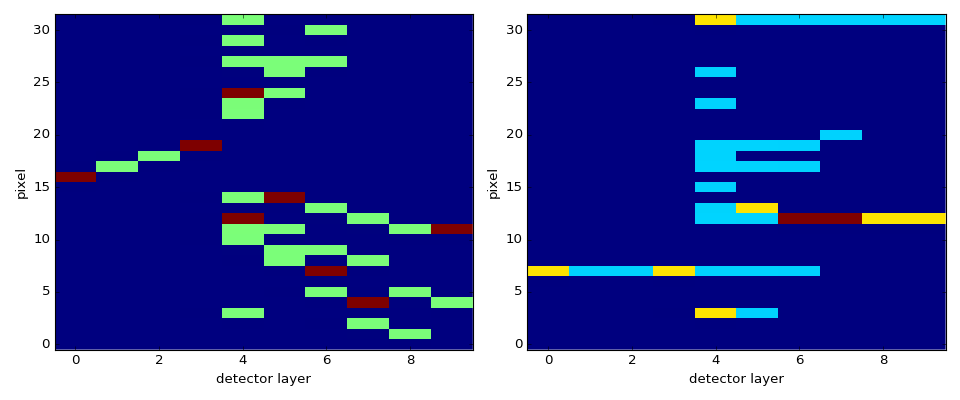

Model target


<IPython.core.display.Javascript object>


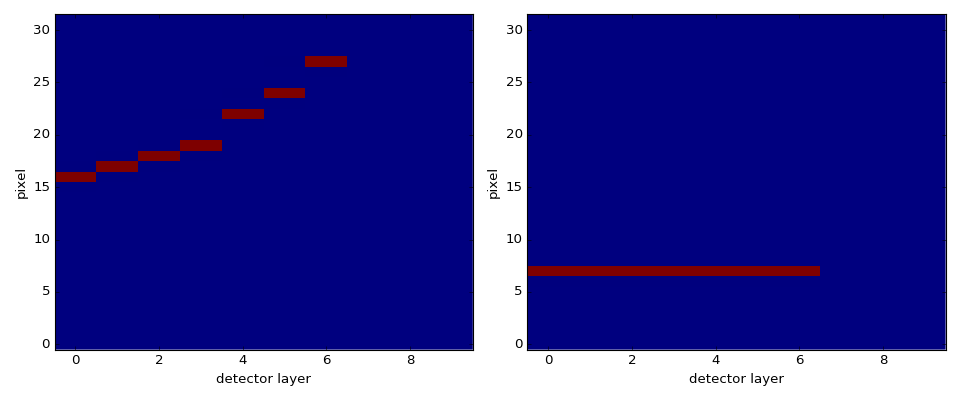

Model prediction


<IPython.core.display.Javascript object>


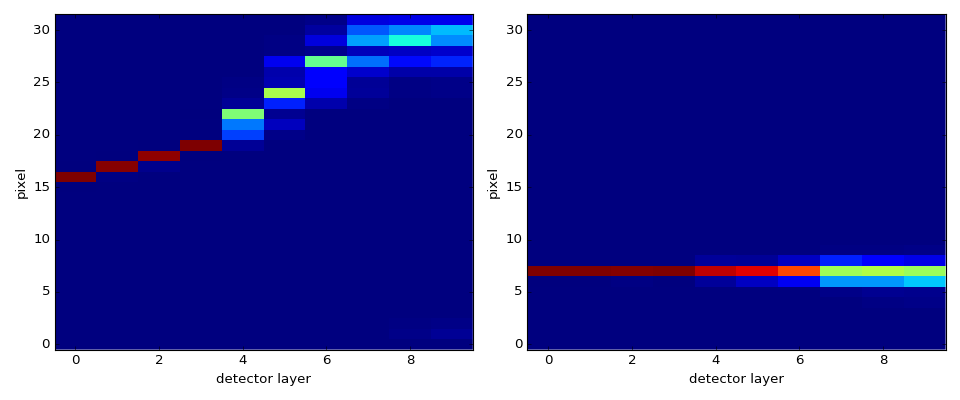

In [176]:
# Visualize predictions
i = 3
print('Model input')
draw_projections(train2_input[i].reshape(hist_shape))
print('Model target')
draw_projections(train2_target[i].reshape(hist_shape))
print('Model prediction')
draw_projections(train2_pred[i].reshape(hist_shape));

In [178]:
calc_hit_accuracy(train2_pred, train2_target, num_seed_layers=seed_size)

0.6400840632720506